#### Data Processing

In [11]:
# Imports and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.signal import butter, filtfilt, welch
from scipy.integrate import trapezoid

fs = 250 
new_data = np.load("trial_3.npy")
df = pd.DataFrame(new_data)

print(f"Data Shape: {df.shape}")
df

Data Shape: (35988, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,-13789.215838,-16455.890710,8137.621956,-1131.579415,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,128.0,679.0,1.741214e+09
1,-13762.639613,-16421.536079,8161.359508,-1097.224784,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741214e+09
2,-13796.346044,-16463.020916,8126.468435,-1139.804857,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741214e+09
3,-13833.874623,-16502.628208,8102.641476,-1177.847526,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741214e+09
4,-13798.715329,-16462.752695,8140.214758,-1135.490970,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,127.0,680.0,1.741214e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
35983,-14085.152934,-16592.638682,7212.125625,-1616.947546,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741215e+09
35984,-14022.232774,-16530.187908,7260.807724,-1553.692109,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,127.0,679.0,1.741215e+09
35985,-14022.836271,-16517.626228,7268.787297,-1535.207216,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741215e+09
35986,-14065.461047,-16569.482275,7224.262622,-1593.008827,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741215e+09


In [36]:
# Labeling columns

# onset and offset of artifacts
df['onset'] = (df[9].shift(1) < 30) & (df[9] >= 30) # First onset is jaw clench and offset is jawclench
df['offset'] = (df[9].shift(-1) < 30)& (df[9] >= 30) # Anastasyas code

num_channels = 11  
column_names = [f"EEG_{i}" for i in range(1, 9)]  # 8 EEG channels
column_names += [f"AUX_{i}" for i in range(1, 4)]  # 3 AUX channels
column_names += ["Timestamp", "Onset", "Offset"]  # Add Onset and Offset

df.columns = column_names 

# Extract EEG channels
selected_eeg_channels = ["EEG_1", "EEG_2", "EEG_3", "EEG_4"]
eeg_data = df[selected_eeg_channels]

# Extract AUX channels
aux_channels = ["AUX_1", "AUX_2", "AUX_3"]
aux_data = df[aux_channels]

# Extract timestamps
timestamps = df["Timestamp"]

print(f"EEG Data Shape: {eeg_data.shape}")
print(f"Timestamps Shape: {timestamps.shape}")
print(f"AUX Channel Shape: {aux_data.shape}") # Make sure these are correctly labeled

df

EEG Data Shape: (35988, 4)
Timestamps Shape: (35988,)
AUX Channel Shape: (35988, 3)


,EEG_1,EEG_2,EEG_3,EEG_4,EEG_5,EEG_6,EEG_7,EEG_8,AUX_1,AUX_2,AUX_3,Timestamp,Onset,Offset
0,-13789.215838,-16455.890710,8137.621956,-1131.579415,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,128.0,679.0,1.741214e+09,False,False
1,-13762.639613,-16421.536079,8161.359508,-1097.224784,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741214e+09,False,False
2,-13796.346044,-16463.020916,8126.468435,-1139.804857,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741214e+09,False,False
3,-13833.874623,-16502.628208,8102.641476,-1177.847526,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741214e+09,False,False
4,-13798.715329,-16462.752695,8140.214758,-1135.490970,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,127.0,680.0,1.741214e+09,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35983,-14085.152934,-16592.638682,7212.125625,-1616.947546,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741215e+09,False,False
35984,-14022.232774,-16530.187908,7260.807724,-1553.692109,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,127.0,679.0,1.741215e+09,False,False
35985,-14022.836271,-16517.626228,7268.787297,-1535.207216,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,128.0,679.0,1.741215e+09,False,False
35986,-14065.461047,-16569.482275,7224.262622,-1593.008827,-187500.022352,-187500.022352,-187500.022352,-187500.022352,338.0,127.0,679.0,1.741215e+09,False,False


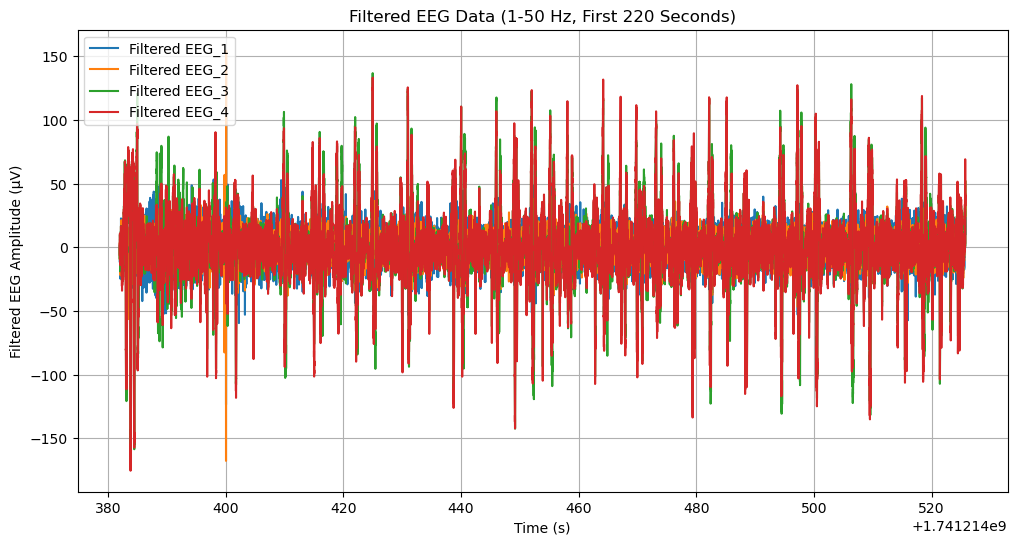

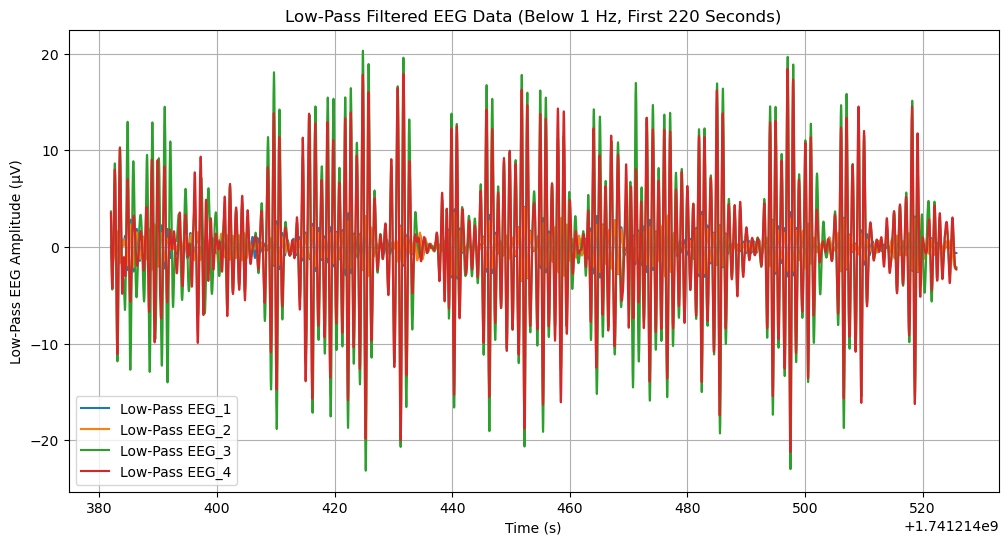

In [3]:
# Applying Bandpass and Lowpass Filters

time_window = 220 
start_idx = 0  
end_idx = int(time_window * fs)

# Bandpass filter function (1-50 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

filtered_eeg = eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
filtered_eeg_segment = filtered_eeg.iloc[start_idx:end_idx, :]

time_segment = timestamps[start_idx:end_idx]  # Corresponding time segment for x-axis

plt.figure(figsize=(12, 6))
for i, col in enumerate(filtered_eeg_segment.columns):
    plt.plot(time_segment, filtered_eeg_segment[col], label=f"Filtered {col}")

plt.xlabel("Time (s)")
plt.ylabel("Filtered EEG Amplitude (µV)")
plt.title(f"Filtered EEG Data (1-50 Hz, First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Lowpass filter for slow drifts (Below 1 Hz) (I dont think this matters for the double blinks)
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

lowpass_filtered_eeg = filtered_eeg.apply(lambda x: lowpass_filter(x, 1, fs))
lowpass_filtered_eeg_segment = lowpass_filtered_eeg.iloc[start_idx:end_idx, :]

plt.figure(figsize=(12, 6))
for i, col in enumerate(lowpass_filtered_eeg_segment.columns):
    plt.plot(time_segment, lowpass_filtered_eeg_segment[col], label=f"Low-Pass {col}")

plt.xlabel("Time (s)")
plt.ylabel("Low-Pass EEG Amplitude (µV)")
plt.title(f"Low-Pass Filtered EEG Data (Below 1 Hz, First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Order of artifact cue for each trial (will only focus on trial_3)
artifacts = np.load("trials.npy")
df_artifacts = pd.DataFrame(artifacts)
df_artifacts

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,jaw_clench,blink_hard,jaw_clench,jaw_clench,double_blink,blink_hard,double_blink,jaw_clench,blink_hard,blink_hard,...,jaw_clench_blink,blink_hard,double_blink,double_blink,jaw_clench_blink,double_blink,double_blink,jaw_clench,double_blink,jaw_clench
1,jaw_clench,jaw_clench_blink,jaw_clench_blink,jaw_clench,blink_hard,double_blink,blink_hard,double_blink,jaw_clench,jaw_clench,...,jaw_clench_blink,jaw_clench,double_blink,double_blink,double_blink,double_blink,double_blink,double_blink,blink_hard,blink_hard
2,jaw_clench,jaw_clench_blink,jaw_clench,jaw_clench_blink,blink_hard,jaw_clench_blink,blink_hard,jaw_clench,jaw_clench_blink,jaw_clench,...,blink_hard,jaw_clench_blink,jaw_clench,jaw_clench_blink,jaw_clench_blink,jaw_clench,double_blink,jaw_clench_blink,double_blink,double_blink


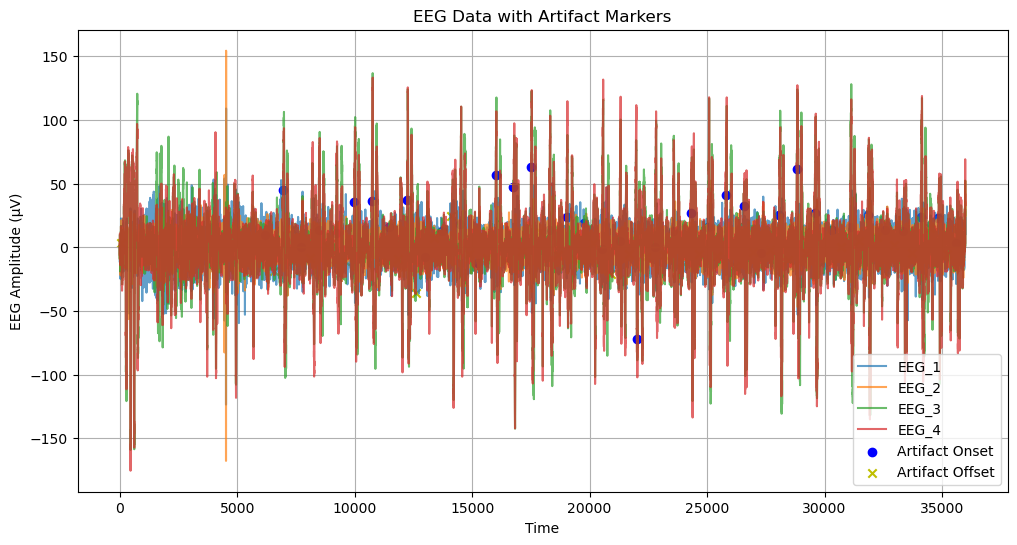

In [5]:
# Data showing onset and offset of double blink artifact

# Extract onset and offset indices for double blink
onset_indices = df[df['Onset'] == True].index
offset_indices = df[df['Offset'] == True].index

# Data with artifact markers
plt.figure(figsize=(12, 6))
for i, col in enumerate(filtered_eeg.columns):
    plt.plot(filtered_eeg[col], label=f"{col}", alpha=0.7)

# Overlay artifact markers for double blink
plt.scatter(onset_indices, filtered_eeg.iloc[onset_indices]['EEG_3'], color='b', label="Artifact Onset", marker='o')
plt.scatter(offset_indices, filtered_eeg.iloc[offset_indices]['EEG_3'], color='y', label="Artifact Offset", marker='x')

plt.xlabel("Time")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Data with Artifact Markers")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Artifact labeling for double blink

# Trial positions that correspond to double blinks IN TRIAL 3
double_blink_positions = df_artifacts.iloc[2] == "double_blink"

# All detected onsets from the EEG DataFrame
all_onsets = df[df["Onset"]].index

# Extract corresponding EEG onset indices
double_blink_onsets = all_onsets[double_blink_positions.values]

print("Double Blink Onsets:", double_blink_onsets) 

Double Blink Onsets: Index([16751, 24295, 26556, 33340, 34847, 35602], dtype='int64')


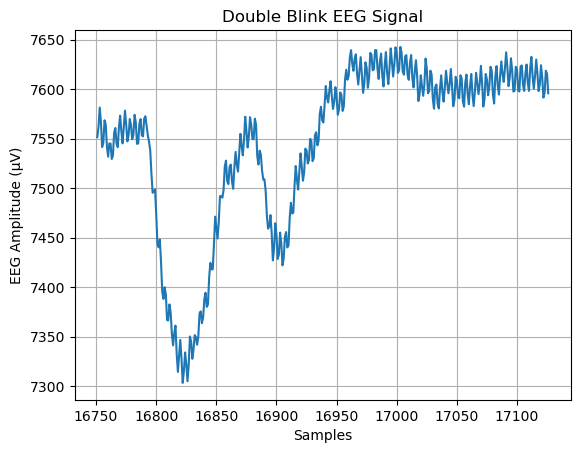

In [7]:
# First detected double blink onset and offset

onset_idx = double_blink_onsets[0] 
offset_idx = onset_idx + int(1.5 * fs)  # Assuming 1.5 s window

offset_idx = min(offset_idx, len(df) - 1)

df['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title="Double Blink EEG Signal")
plt.xlabel("Samples")
plt.ylabel("EEG Amplitude (µV)")
plt.grid(True)
plt.show()

#### Starting on Classification

In [8]:
# Epoch extraction, around each double blink (pos class) and non-blink (neg class)

epoch_window_samples = int(1 * fs)  # 1 s before and after onset
epochs = []
labels = []  # 1 = double blink, 0 = non-blink

# Extract double blink epochs using double_blink_onsets
# assuming indexes are the same for onset and df_artifact
for onset in double_blink_onsets:
    start_epoch = max(onset - epoch_window_samples, 0)
    end_epoch = min(onset + epoch_window_samples, len(filtered_eeg)) # setting window
    epoch = filtered_eeg.iloc[start_epoch:end_epoch].values # extract data
    if epoch.shape[0] == 2 * epoch_window_samples:
        epochs.append(epoch)
        labels.append(1)

# Extract non-blink epochs, randomly sampling
num_positive = len(epochs)
possible_indices = list(set(range(epoch_window_samples, len(filtered_eeg) - epoch_window_samples)) - set(double_blink_onsets))
random_indices = random.sample(possible_indices, num_positive) # randomizing cfreates balanced dataset for model
for idx in random_indices:
    epoch = filtered_eeg.iloc[idx - epoch_window_samples: idx + epoch_window_samples].values
    if epoch.shape[0] == 2 * epoch_window_samples:
        epochs.append(epoch)
        labels.append(0)

epochs = np.array(epochs)
labels = np.array(labels)
print("Epochs shape:", epochs.shape)
print("Labels distribution:", np.unique(labels, return_counts=True))

Epochs shape: (12, 500, 4)
Labels distribution: (array([0, 1]), array([6, 6]))


In [9]:
# Feature extraction from epochs: 
# time-domain (mean, variance) and frequency-domain (bandpower in alpha and beta bands) features
 
def compute_bandpower(signal, fs, band):
    freqs, psd = welch(signal, fs, nperseg=256)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return trapezoid(psd[idx_band], freqs[idx_band])

def extract_features(epoch, fs):
    feats = []
    for ch in range(epoch.shape[1]):
        sig = epoch[:, ch]
        mean_val = np.mean(sig)
        var_val = np.var(sig)
        alpha_bp = compute_bandpower(sig, fs, (8, 13))
        beta_bp = compute_bandpower(sig, fs, (13, 30))
        feats.extend([mean_val, var_val, alpha_bp, beta_bp])
    return np.array(feats)

feature_list = [extract_features(epoch, fs) for epoch in epochs]
features = np.array(feature_list)
print("Features shape:", features.shape)
# shape should be 4 eeg channels x the 4 features

Features shape: (12, 16)


In [10]:
# Training SVM classifier

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(acc * 100))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred)) 

# Model's not performing very well (but this is the best it performs)

Test Accuracy: 75.00%
Confusion Matrix:
[[2 0]
 [1 1]]


In [20]:
df.shape

(35988, 12)

In [ ]:
df_trying = df.iloc[0:(int(200*fs)+1)]

In [ ]:
df_trying = df_trying[[11, 2, 3, 9]]
df_trying[11] = np.array(range(0,len(df_trying)))/fs

In [34]:
df_trying

,11,2,3,9
0,0.000,8137.621956,-1131.579415,128.0
1,0.004,8161.359508,-1097.224784,128.0
2,0.008,8126.468435,-1139.804857,127.0
3,0.012,8102.641476,-1177.847526,128.0
4,0.016,8140.214758,-1135.490970,127.0
...,...,...,...,...
35983,143.932,7212.125625,-1616.947546,127.0
35984,143.936,7260.807724,-1553.692109,127.0
35985,143.940,7268.787297,-1535.207216,128.0
35986,143.944,7224.262622,-1593.008827,127.0


In [43]:
df_trying = df[['Timestamp', 'EEG_3', 'EEG_4', 'Onset', 'Offset']]
df_trying = df_trying.iloc[0:(int(200*fs)+1)]
df_trying['Timestamp'] = np.array(range(0,len(df_trying)))/fs

In [47]:
blinks_qt = np.load('tblinks.npy')

In [70]:
idx = 3
start = blinks_qt[idx][0]
stop = blinks_qt[idx][-1]

<Axes: >

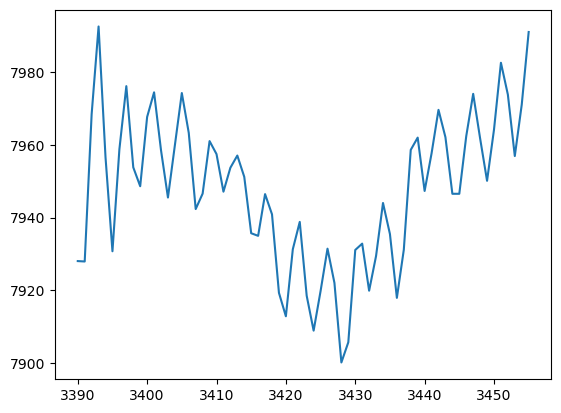

In [71]:
df_trying[(df_trying['Timestamp'] >= start) & (df_trying['Timestamp'] <= stop)]['EEG_3'].plot()